# Quantum teleportation

In [17]:
from qiskit import *


Il teletrasporto quantistico è un protocollo fondamentale nell'informatica quantistica che permette di trasferire lo stato di un qubit da un punto A (Alice) a un punto B (Bob) utilizzando due risorse fondamentali:
- L'entanglement quantistico
- La comunicazione classica

Per implementare questo protocollo utilizzeremo un circuito quantistico composto da 3 qubit:
 - q0: contiene lo stato quantistico che vogliamo trasferire
 - q1: qubit di Alice utilizzato per l'entanglement
 - q2: qubit di Bob che riceverà lo stato finale

# Costruzione del circuito

In [18]:
circuit = QuantumCircuit(3,3)
# Configurazione del circuito:
# q0: Contiene lo stato quantistico da trasferire
# q1: Qubit di Alice per l'entanglement
# q2: Qubit di Bob che riceverà lo stato

# Inizializzazione dello stato da teletrasportare 
circuit.x(0) # Prepariamo il qubit 0 nello stato |1>

circuit.barrier() 

# Generazione della risorsa di entanglement
circuit.h(1)  # Sovrapposizione sul qubit di Alice
circuit.cx(1,2)  # Creazione dell'entanglement tra i qubit di Alice e Bob

circuit.barrier() 

# Protocollo di Alice
circuit.cx(0,1) # Intreccio dello stato da teletrasportare con il qubit di Alice
circuit.h(0) # Trasformazione di base per la misura

circuit.barrier()

# Fase di misura di Alice
circuit.measure([0,1],[0,1])  # Acquisizione dell'informazione per la correzione

circuit.barrier()

# Operazioni di recupero di Bob
circuit.cx(1,2) # Prima correzione basata sul secondo bit classico
circuit.cz(0,2) # Seconda correzione basata sul primo bit classico

# Verifica finale
circuit.measure([2],[2]) # Misura dello stato teletrasportato

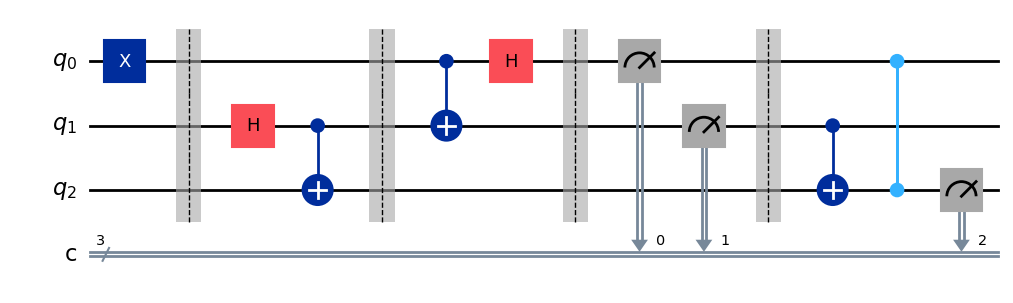

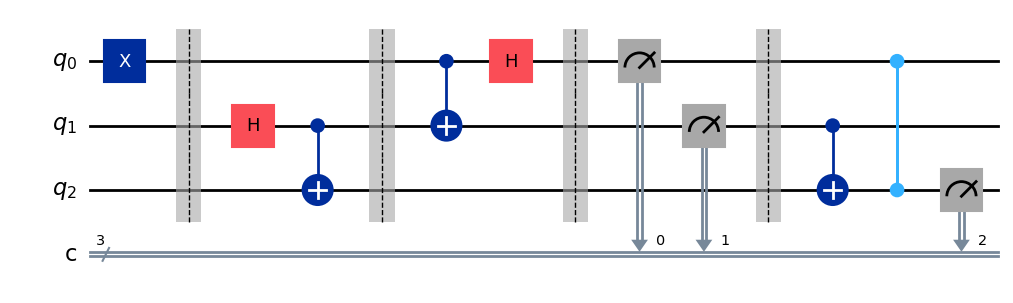

In [19]:
# Disegno del circuito
%matplotlib inline
circuit.draw(output='mpl') 

# Esecuzione del circuito di quantum teleportation

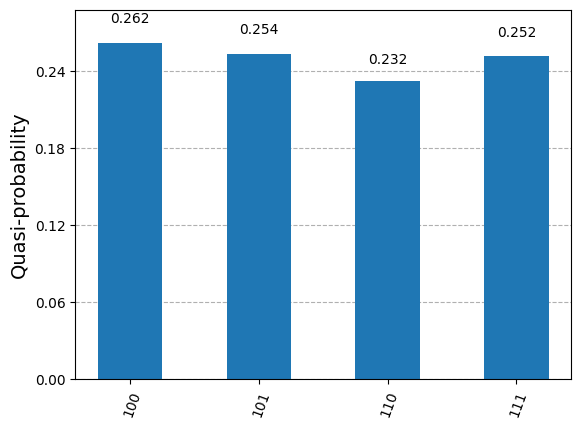

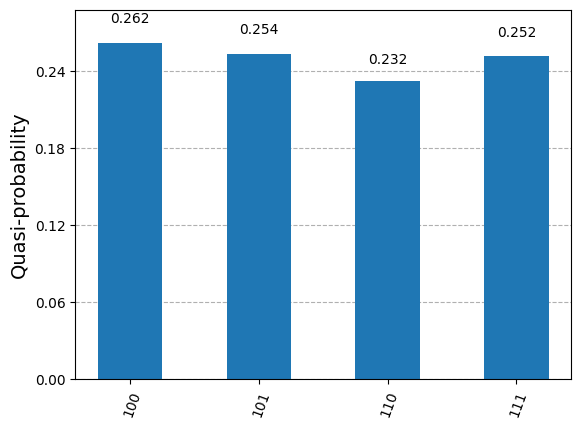

In [20]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Inizializziamo il simulatore QASM che esegue il circuito come farebbe un computer quantistico reale
simulator = Aer.get_backend('qasm_simulator') 

# Compiliamo il circuito per ottimizzarlo per il backend specifico
compiled_circuit = transpile(circuit, simulator)

# Eseguiamo la simulazione con 1024 shots (ripetizioni)
result = simulator.run(compiled_circuit, shots=1024).result()

# Creiamo un istogramma normalizzato dividendo ogni conteggio per il numero totale di shots
counts = result.get_counts(circuit)
plot_histogram({k: v/1024 for k, v in counts.items()})

# Teleporting Circuit usando sottocircuiti

In questa sezione, il protocollo di teletrasporto quantistico è stato implementato utilizzando un approccio modulare, suddividendo il circuito in componenti funzionali distinte. Questa strutturazione permette di gestire in modo più chiaro e organizzato le diverse fasi del protocollo.

c:\Users\laggy\miniconda3\envs\quant\Lib\site-packages\qiskit\circuit\quantumcircuit.py:3394: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


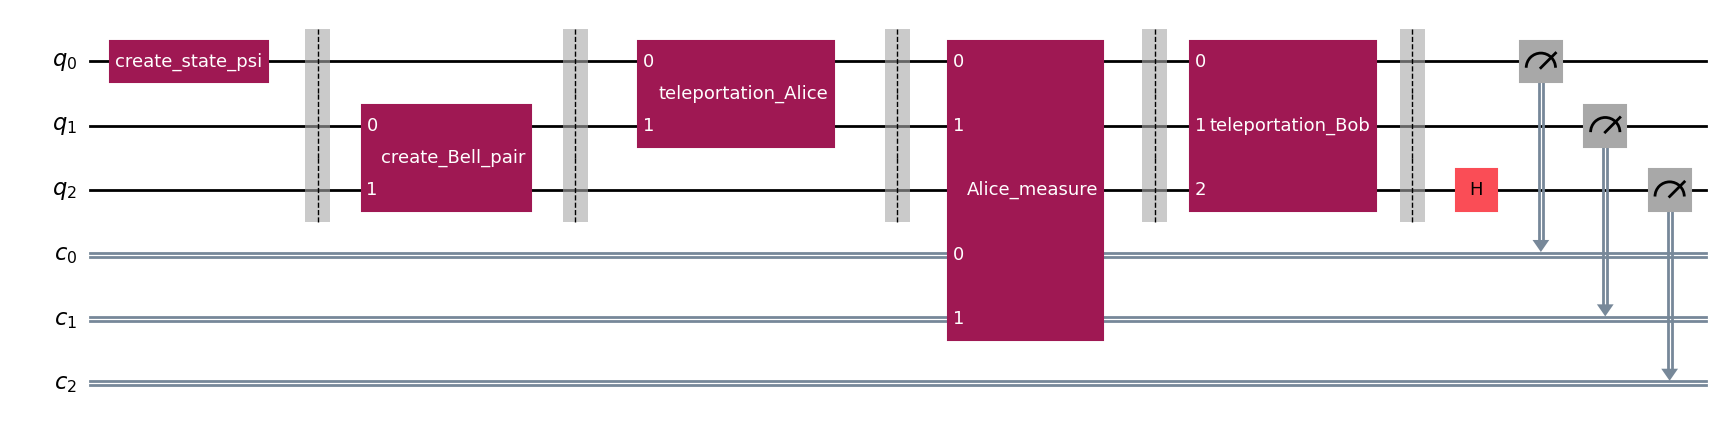

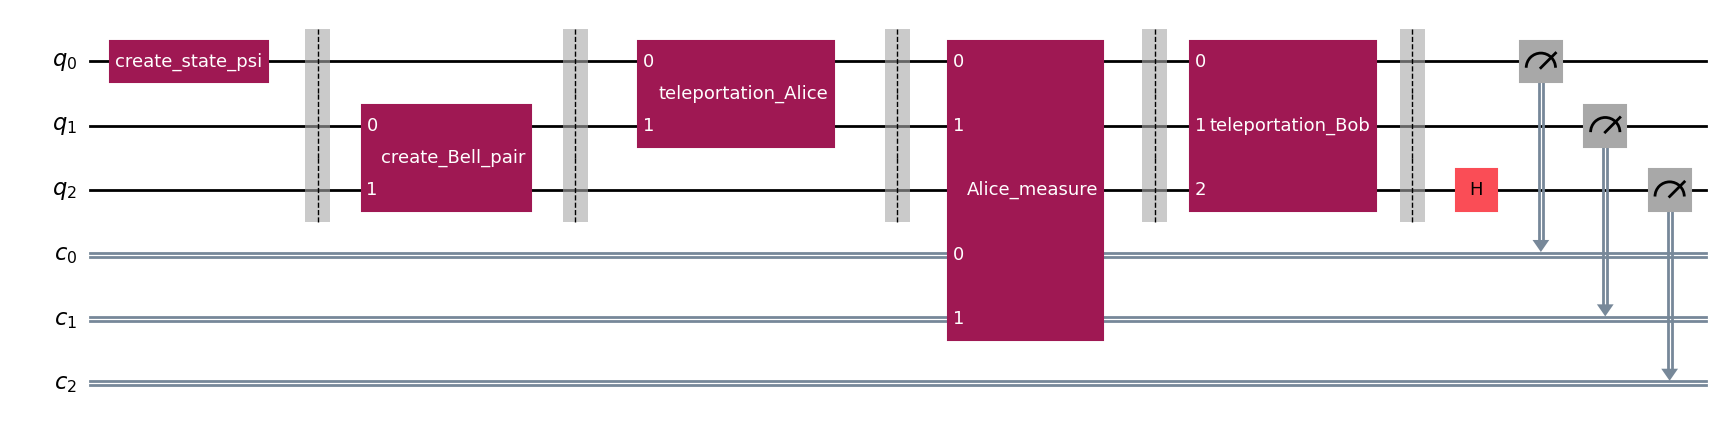

In [21]:
# Funzione per creare lo stato iniziale da teletrasportare
# Applica una porta Hadamard seguita da una rotazione Rz(theta)
def create_state_psi(theta):
    # Inizializza un circuito con un singolo qubit
    create_circuit = QuantumCircuit(1, name='create_state_psi')
    # Porta Hadamard per creare una sovrapposizione
    create_circuit.h(0)
    # Rotazione attorno all'asse z di un angolo theta
    create_circuit.rz(theta, 0)
    return create_circuit

# Funzione per generare una coppia di Bell entangled
# Questo è il canale quantistico necessario per il teletrasporto
def create_Bell_pair():
    # Inizializza un circuito con due qubit
    create_circuit = QuantumCircuit(2, name='create_Bell_pair')
    # Hadamard per creare sovrapposizione sul primo qubit
    create_circuit.h(0)
    # CNOT per creare l'entanglement tra i due qubit
    create_circuit.cx(0, 1)
    return create_circuit

# Funzione che implementa le operazioni quantistiche di Alice
# Queste operazioni codificano lo stato da teletrasportare
def teleportation_Alice():
    # Circuito per le operazioni di Alice sui due qubit
    teleportation_Alice_circuit = QuantumCircuit(2, name='teleportation_Alice')
    # CNOT tra qubit dello stato e qubit di Bell
    teleportation_Alice_circuit.cx(0, 1)
    # Hadamard sul qubit dello stato
    teleportation_Alice_circuit.h(0)
    return teleportation_Alice_circuit

# Funzione per la misura dei qubit di Alice
# I risultati verranno usati da Bob per il recupero dello stato
def Alice_measure():
    # Circuito con due qubit e due bit classici per le misure
    Alice_measure_circuit = QuantumCircuit(2, 2, name='Alice_measure')
    # Misura entrambi i qubit di Alice
    Alice_measure_circuit.measure([0, 1], [0, 1])
    return Alice_measure_circuit

# Funzione per le operazioni correttive di Bob
# Basate sui risultati delle misure di Alice
def teleportation_Bob():
    # Circuito per le operazioni di Bob sui tre qubit
    teleportation_Bob_circuit = QuantumCircuit(3, name='teleportation_Bob')
    # CNOT controllato dal secondo bit classico
    teleportation_Bob_circuit.cx(1, 2)
    # CZ controllato dal primo bit classico
    teleportation_Bob_circuit.cz(0, 2)
    return teleportation_Bob_circuit

# Funzione principale che costruisce l'intero circuito di teletrasporto
# Parametro theta: angolo della rotazione dello stato iniziale
def build_circuit(theta):
    # Inizializza il circuito completo
    circuit = QuantumCircuit(3, 3)

    # Fase 1: Preparazione dello stato da teletrasportare
    circuit.append(create_state_psi(theta).to_instruction(), [0])
    circuit.barrier()

    # Fase 2: Creazione della risorsa di entanglement
    circuit.append(create_Bell_pair().to_instruction(), [1, 2])
    circuit.barrier()

    # Fase 3: Operazioni di Alice
    circuit.append(teleportation_Alice().to_instruction(), [0, 1])
    circuit.barrier()

    # Fase 4: Misurazioni di Alice
    circuit.append(Alice_measure().to_instruction(), [0, 1], [0, 1])
    circuit.barrier()

    # Fase 5: Operazioni correttive di Bob
    circuit.append(teleportation_Bob().to_instruction(), [0, 1, 2])
    circuit.barrier()

    # Fase 6: Misura finale nella base di Hadamard
    circuit.h(2)  # Trasformazione di base per la misura
    circuit.measure([0, 1, 2], [0, 1, 2])
    
    return circuit

# Creazione del circuito con un angolo theta specifico
circuit = build_circuit(0.01)
# Visualizzazione del circuito
circuit.draw(output='mpl')

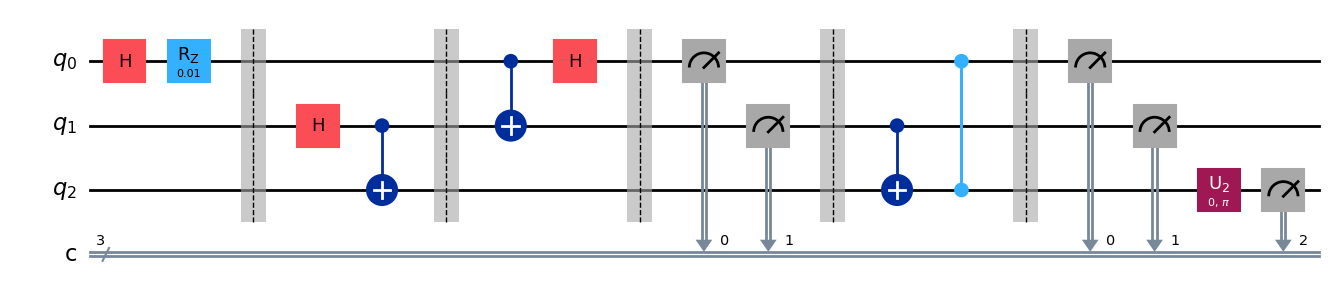

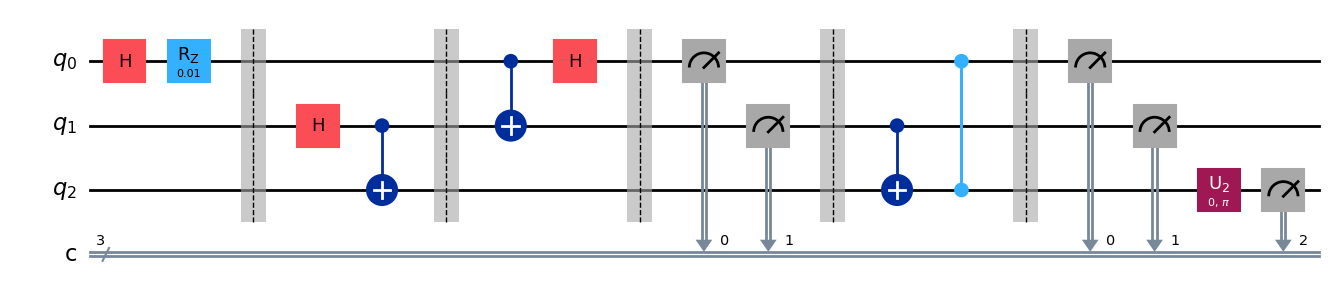

In [22]:
circuit.decompose().draw(output='mpl') # Decomposizione del circuito

In [23]:
simulator = Aer.get_backend('qasm_simulator')

result= transpile(circuit,backend=simulator)
result = simulator.run(result, shots=1024).result()

counts = result.get_counts(circuit)

print(counts)

num_c2_zero= sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')

{'000': 269, '011': 262, '010': 256, '001': 237}


# Loop che itera su numerosi angoli iniziali $\theta$

Per valutare l'efficacia del nostro protocollo di teletrasporto quantistico, eseguiremo una serie di simulazioni variando l'angolo theta dello stato iniziale. Questo ci permetterà di osservare come il protocollo si comporta con stati quantistici diversi.

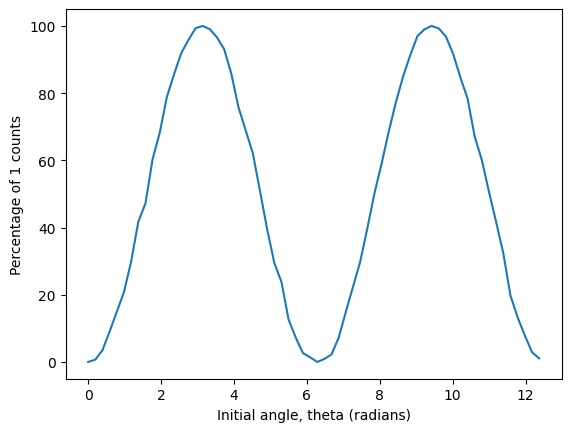

In [24]:
import numpy as np

# Creiamo un array di angoli theta da 0 a 4π
thetas = np.arange(0, 4*np.pi, np.pi/16)

# Inizializziamo il simulatore
simulator = Aer.get_backend('qasm_simulator')

# Lista per memorizzare le percentuali di '1' misurati
percent_ones = []

# Eseguiamo la simulazione per ogni valore di theta
for theta in thetas:
    # Costruiamo e compiliamo il circuito
    circuit = build_circuit(theta)
    compiled_circuit = transpile(circuit, simulator)
    
    # Eseguiamo la simulazione con 1024 shots
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts(circuit)
    
    # Calcoliamo la percentuale di '1' nel qubit finale
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)

# Visualizziamo i risultati
import matplotlib.pyplot as plotter
plotter.plot(thetas, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

# Esecuzione su una macchina reale

In [25]:
thetas = np.arange(0, 4*np.pi, np.pi/16)

circuits = []

for theta in thetas:
    circuit = build_circuit(theta)
    circuits.append(circuit)

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.compiler import assemble

service = QiskitRuntimeService(channel="ibm_quantum") # Inizializziamo il servizio Qiskit Runtime

backend = service.least_busy(operational=True, simulator=False) # Scegliamo il backend meno occupato
target = backend.target

# Decompose custom instructions to standard gate set
decomposed_circuits = [circuit.decompose() for circuit in circuits]

transpiled_circuits = transpile(decomposed_circuits, 
                                backend=backend, 
                                initial_layout=[6, 8, 7]) # Trasposizione dei circuiti per il backend scelto

pm = generate_preset_pass_manager(target=target, optimization_level=3)
isa_circuits = pm.run(transpiled_circuits)

sampler = Sampler(mode=backend)
job = sampler.run(isa_circuits, shots=512)

print(job.job_id()) # Stampa l'ID del lavoro


cxvj7dd4a290008xvavg


In [27]:
# Otteniamo il backend del simulatore QASM
simulator = Aer.get_backend('qasm_simulator')

# Compiliamo i circuiti per il simulatore specifico
compiled_circuits = transpile(circuits, simulator)

# Eseguiamo la simulazione con 512 shots per ogni circuito
simulate_result = simulator.run(compiled_circuits, shots=512).result()

# Confronto tra Simulazione e Dispositivo Reale

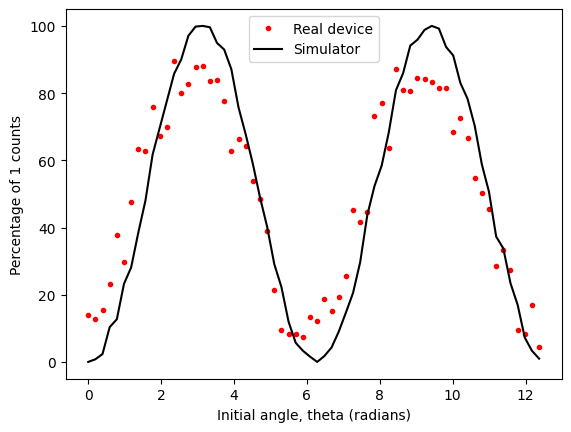

In [28]:
# Elaborazione dei risultati dal dispositivo reale
result = job.result()
percent_ones = []


# Estrai i conteggi per ciascun circuito
counts_list = []
for res in result:
    counts = res.data.c.get_counts()  # Conteggi per il circuito
    counts_list.append(counts)

# Calcola le percentuali di '1' per ciascun circuito
percent_ones = []
for counts in counts_list:
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones * 100. / 512)

# Calcolo delle percentuali per la simulazione
percent_ones_sim = []
for circuit in circuits:
    thiscircuit_counts = simulate_result.get_counts(circuit)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones * 100. / 512)

# Visualizzazione dei risultati
plotter.plot(thetas, percent_ones, 'r.', label='Real device')  # Punti rossi per il dispositivo reale
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')  # Linea nera per il simulatore
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()


# Quantum teleportation su lunghe distanze

In [29]:
# Prepariamo un array di angoli theta da 0 a 4π
thetas = np.arange(0, 4*np.pi, np.pi/16)

# Lista per memorizzare i circuiti
circuits_classicalcontrol = []

# Creiamo un circuito per ogni valore di theta
for theta in thetas:
    # Inizializziamo i registri classici e quantistici
    cr1 = ClassicalRegister(1)  # Registro classico per il primo bit
    cr2 = ClassicalRegister(1)  # Registro classico per il secondo bit
    cr3 = ClassicalRegister(1)  # Registro classico per la misura finale
    qr = QuantumRegister(3)     # Registro quantistico per i tre qubit
    circuit = QuantumCircuit(qr, cr1, cr2, cr3)

    # Fase 1: Preparazione dello stato da teletrasportare
    circuit.h(0)        # Hadamard per creare sovrapposizione
    circuit.rz(theta, 0)  # Rotazione per preparare lo stato specifico
    circuit.barrier()

    # Fase 2: Creazione della coppia di Bell
    circuit.h(1)     # Hadamard sul primo qubit di Bell
    circuit.cx(1, 2)  # CNOT per creare l'entanglement
    circuit.barrier()

    # Fase 3: Operazioni di Alice
    circuit.cx(0, 1)  # CNOT tra stato e qubit di Bell
    circuit.h(0)      # Hadamard sullo stato
    circuit.barrier()

    # Fase 4: Misurazioni di Alice e comunicazione classica
    circuit.measure([0,1], [0,1])
    circuit.barrier()

    # Fase 5: Operazioni di Bob condizionate dai bit classici
    circuit.x(2).c_if(cr2, 1) # X gate condizionato dal secondo bit
    circuit.z(2).c_if(cr1, 1) # Z gate condizionato dal primo bit
    circuit.barrier()

    # Fase 6: Misura finale nella base di Hadamard
    circuit.h(2)
    circuit.measure([2], [2])

    circuits_classicalcontrol.append(circuit)

# Visualizziamo il primo circuito come esempio
circuits_classicalcontrol[0].draw()

┌───┐┌───────┐ ░            ░      ┌───┐ ░ ┌─┐    ░                ░ »
q1170_0: ┤ H ├┤ Rz(0) ├─░────────────░───■──┤ H ├─░─┤M├────░────────────────░─»
         └───┘└───────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                ░ »
q1170_1: ───────────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░────────────────░─»
                        ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐  ░ »
q1170_2: ───────────────░──────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├──░─»
                        ░      └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘  ░ »
                                                     ║  ║       ║   ┌──╨──┐   »
 c192: 1/════════════════════════════════════════════╩══╬═══════╬═══╡ 0x1 ╞═══»
                                                     0  ║    ┌──╨──┐└─────┘   »
 c193: 1/═══════════════════════════════════════════════╩════╡ 0x1 ╞══════════»
                                                        0    └─────┘          »
 c194: 1/═════════════════════════════════════════════════════════════════════»
                                                                              »
«                 
«q1170_0: ────────
«                 
«q1170_1: ────────
«         ┌───┐┌─┐
«q1170_2: ┤ H ├┤M├
«         └───┘└╥┘
« c192: 1/══════╬═
«               ║ 
« c193: 1/══════╬═
«               ║ 
« c194: 1/══════╩═
«               0

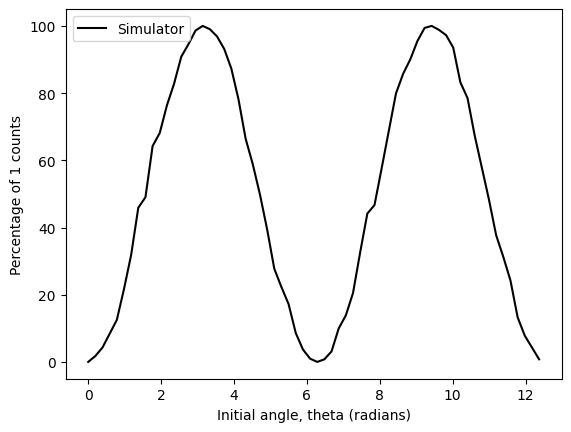

In [30]:
# Configurazione del simulatore QASM
simulator = Aer.get_backend('qasm_simulator')

# Compilazione dei circuiti per il simulatore
compiled_circuits = transpile(circuits_classicalcontrol, simulator)

# Esecuzione della simulazione con 512 shots per ogni circuito
simulate_result = simulator.run(compiled_circuits, shots=512).result()

# Analisi dei risultati
percent_ones_sim = []

# Calcolo delle percentuali per ogni circuito
for ii in range(len((circuits))):
    # Otteniamo i conteggi per questo circuito
    thiscircuit_counts = simulate_result.get_counts(ii)
    # Calcoliamo la percentuale di '1' nel qubit finale
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)

# Visualizzazione dei risultati
plotter.plot(thetas, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.legend()
plotter.show()

In [31]:
import qiskit
print(qiskit.__version__) # STampa la versione di Qiskit installata (nel mio caso la 1.2.4)

1.2.4
